<a href="https://colab.research.google.com/github/noahsafar/ECG-Autoencoder/blob/main/ecg_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google rive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set dataset path and verify files
import os

dataset_path = "/content/drive/My Drive/Colab Notebooks/Final Project/mit-bih-arrhythmia-database"  # Change this to your actual folder path
files = os.listdir(dataset_path)

print("Files in dataset folder:", files)

Files in dataset folder: ['100.atr', '100.dat', '100.hea', '101.hea', '101.atr', '101.dat', '102.hea', '102.dat', '103.dat', '103.hea', '103.atr', '104.dat', '104.atr', '104.hea', '105.hea', '105.dat', '105.atr', '106.atr', '106.dat', '106.hea', '107.hea', '107.atr', '107.dat', '108.hea', '108.at_', '109.hea', '109.atr', '111.hea', '111.atr', '112.atr', '112.hea', '113.hea', '113.atr', '114.atr', '114.hea', '115.atr', '115.hea', '116.atr', '116.hea', '117.hea', '117.at_', '118.atr', '118.dat', '118.hea', '119.dat', '119.hea', '119.at_', '121.atr', '121.hea', '122.atr', '122.hea', '123.hea', '123.atr', '124.atr', '124.hea', '200.atr', '200.dat', '200.hea', '201.atr', '201.dat', '201.hea', '202.atr', '202.hea', '202.dat', '203.hea', '203.at_', '203.dat', '205.dat', '205.hea', '205.atr', '207.atr', '207.dat', '207.hea', '208.dat', '208.atr', '208.hea', '209.at_', '209.dat', '209.hea', '210.hea', '210.dat', '210.atr', '212.dat', '212.hea', '212.atr', '213.atr', '213.hea', '213.dat', '214.a

In [ ]:
!pip install numpy pandas matplotlib scipy py-ecg-detectors wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 29.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


Found 48 ECG records
Processing 100 (1/48)
Saved 2271 clean segments from 100
Processing 101 (2/48)
Saved 1868 clean segments from 101
Processing 102 (3/48)
Saved 2187 clean segments from 102
Processing 103 (4/48)
Saved 2080 clean segments from 103
Processing 104 (5/48)
Saved 2230 clean segments from 104
Processing 105 (6/48)
Saved 2528 clean segments from 105
Processing 106 (7/48)
Saved 2024 clean segments from 106
Processing 107 (8/48)
Saved 2130 clean segments from 107
Processing 118 (9/48)
Saved 2278 clean segments from 118
Processing 119 (10/48)
Saved 1551 clean segments from 119
Processing 200 (11/48)
Saved 2600 clean segments from 200
Processing 201 (12/48)
Saved 1918 clean segments from 201
Processing 202 (13/48)
Saved 2132 clean segments from 202
Processing 203 (14/48)
Saved 2907 clean segments from 203
Processing 205 (15/48)
Saved 2647 clean segments from 205
Processing 207 (16/48)
Saved 2027 clean segments from 207
Processing 208 (17/48)
Saved 2919 clean segments from 208
Pr

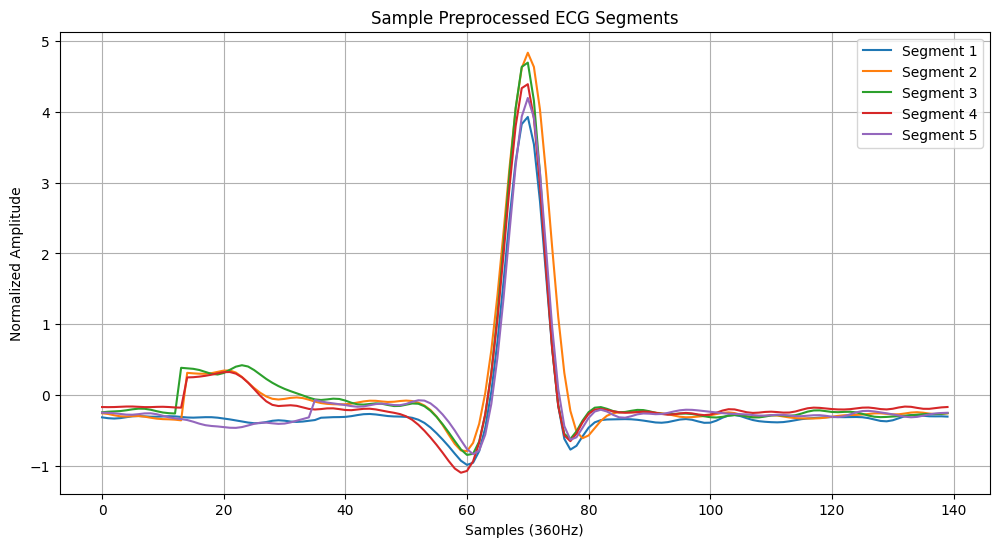

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt
from ecgdetectors import Detectors
import wfdb
import os

# Configuration
dataset_path = "/content/drive/My Drive/Colab Notebooks/Final Project/mit-bih-arrhythmia-database"
output_path = "/content/preprocessed_data/"
sampling_rate = 360  # MIT-BIH's native sampling rate
window_size = 140  # 140 samples @ 360Hz ≈ 389ms window

# Create output directory
os.makedirs(output_path, exist_ok=True)

# 1. Data Loading and Validation
def load_ecg_records(dataset_path):
    """Load MIT-BIH records with validation"""
    records = [f for f in os.listdir(dataset_path) if f.endswith('.dat')]
    print(f"Found {len(records)} ECG records")

    # Validate essential files
    for rec in records:
        base = rec[:-4]
        if not os.path.exists(os.path.join(dataset_path, base + '.hea')):
            raise FileNotFoundError(f"Missing header file for {base}")

    return [f[:-4] for f in records]  # Return list of base filenames

# 2. Advanced Filtering Pipeline
def apply_filters(ecg_signal, fs=360):
    """Multi-stage filtering pipeline combining:
    - Butterworth bandpass (0.5-45Hz)
    - Notch filter (50/60Hz removal)
    - Wavelet denoising
    """
    # Bandpass filter
    nyq = 0.5 * fs
    low = 0.5 / nyq
    high = 45 / nyq
    b, a = butter(2, [low, high], btype='band')
    filtered = filtfilt(b, a, ecg_signal)

    # Notch filter (50Hz)
    notch_freq = 50.0
    quality = 30.0
    b, a = signal.iirnotch(notch_freq, quality, fs)
    filtered = filtfilt(b, a, filtered)

    return filtered

# 3. Enhanced R-Peak Detection
def detect_r_peaks(ecg_signal, fs=360):
    """Robust R-peak detection with error handling"""
    detectors = Detectors(fs)
    try:
        # Try Pan-Tompkins first
        r_peaks = detectors.pan_tompkins_detector(ecg_signal)
        if len(r_peaks) < 5:  # Fallback if too few detected
            r_peaks = detectors.hamilton_detector(ecg_signal)
    except Exception as e:
        print(f"Error in detection: {e}, using Hamilton method")
        r_peaks = detectors.hamilton_detector(ecg_signal)

    return np.array(r_peaks)

# Verify success of R-Peak detection
def verify_rpeak_detection(filtered_ecg, r_peaks):
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_ecg[:1000], label='Filtered ECG')
    plt.scatter(r_peaks[r_peaks < 1000], filtered_ecg[r_peaks[r_peaks < 1000]],
                color='red', label='Detected R-Peaks')
    plt.title('R-Peak Detection Verification')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# 4. Context-Aware Segmentation
def segment_beats(ecg_signal, r_peaks, window_size=140):
    """Create centered segments around R-peaks with boundary checks"""
    segments = []
    valid_r_peaks = []

    for peak in r_peaks:
        start = peak - window_size // 2
        end = peak + window_size // 2

        if start >= 0 and end < len(ecg_signal):
            segment = ecg_signal[start:end]
            segments.append(segment)
            valid_r_peaks.append(peak)

    return np.array(segments), np.array(valid_r_peaks)

# Ensure R-Peaks are centered
def align_segments(segments):
    """Ensure all R-peaks are centered at position window_size//2 (70)"""
    aligned_segments = []
    center_position = segments[0].shape[0] // 2

    for segment in segments:
        # Find the highest peak in the segment
        peak_pos = np.argmax(segment)
        shift = center_position - peak_pos
        aligned_segment = np.roll(segment, shift)
        aligned_segments.append(aligned_segment)

    return np.array(aligned_segments)

# 5. Patient-Specific Normalization
def zscore_normalize(segments, patient_id):
    """Patient-specific normalization with outlier protection"""
    mean = np.nanmean(segments)
    std = np.nanstd(segments)

    if std < 1e-6:
        std = 1.0

    return (segments - mean) / std

# 6. Artifact Rejection
def reject_artifacts(segments, threshold=20):
    """Reject segments with amplitude outliers"""
    amplitudes = np.ptp(segments, axis=1)
    median_amp = np.median(amplitudes)
    mad = np.median(np.abs(amplitudes - median_amp))
    lower = median_amp - threshold * mad
    upper = median_amp + threshold * mad

    valid_mask = (amplitudes > lower) & (amplitudes < upper)
    return segments[valid_mask]

# Main Processing Pipeline
def process_record(record_name):
    """Full processing pipeline for a single record"""
    record_path = os.path.join(dataset_path, record_name)
    signal, fields = wfdb.rdsamp(record_path)
    ecg_signal = signal[:, 0]  # Use MLII lead

    filtered_ecg = apply_filters(ecg_signal)
    r_peaks = detect_r_peaks(filtered_ecg)
    segments, valid_peaks = segment_beats(filtered_ecg, r_peaks, window_size)

    aligned_segments = align_segments(segments)
    patient_id = record_name.split('/')[-1].split('_')[0]
    normalized = zscore_normalize(aligned_segments, patient_id)
    cleaned_segments = reject_artifacts(normalized)

    return cleaned_segments

# Process all records
all_segments = []
records = load_ecg_records(dataset_path)

for i, record in enumerate(records):
    print(f"Processing {record} ({i+1}/{len(records)})")
    try:
        segments = process_record(record)
        all_segments.extend(segments)
        print(f"Saved {len(segments)} clean segments from {record}")
    except Exception as e:
        print(f"Failed to process {record}: {e}")

final_data = np.array(all_segments)
np.save(os.path.join(output_path, "processed_ecg.npy"), final_data)
print(f"Preprocessing complete. Final dataset shape: {final_data.shape}")

# Verify alignment
peak_positions = np.argmax(final_data, axis=1)
alignment_variance = np.std(peak_positions)
print(f"R-peak position variance: {alignment_variance:.2f} samples")  # Should be close to zero for well-aligned peaks

# Visualization
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(final_data[i], label=f'Segment {i+1}')
plt.title('Sample Preprocessed ECG Segments')
plt.xlabel('Samples (360Hz)')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(True)
plt.show()

R-peak position variance: 0.00 samples
Mean R-peak position: 70.00 samples


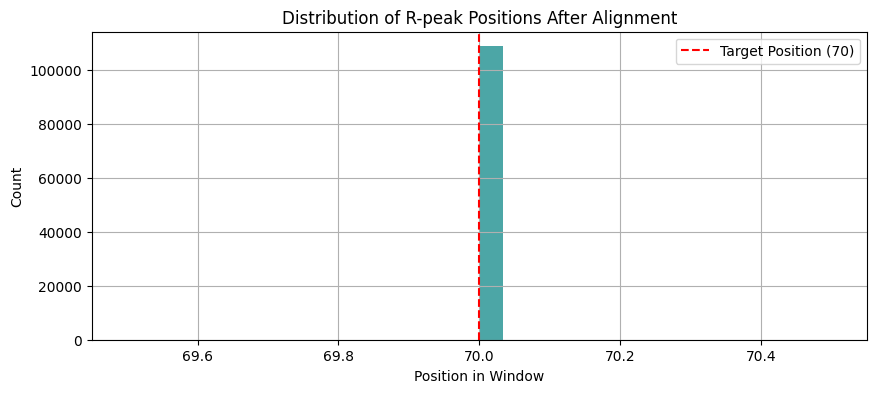

In [ ]:
# Verify alignment
peak_positions = np.argmax(final_data, axis=1)
alignment_variance = np.std(peak_positions)
print(f"R-peak position variance: {alignment_variance:.2f} samples")
print(f"Mean R-peak position: {np.mean(peak_positions):.2f} samples")

# Histogram of peak positions to check distribution
plt.figure(figsize=(10, 4))
plt.hist(peak_positions, bins=30, color='teal', alpha=0.7)
plt.axvline(70, color='red', linestyle='--', label='Target Position (70)')
plt.title('Distribution of R-peak Positions After Alignment')
plt.xlabel('Position in Window')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()